# MADCAT

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import pycountry
import matplotlib.dates as mdates
import time
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("./data/Attacks from Countries.csv")

exception = {
    "Russia": "Russian Federation",
    "South Korea": "Korea, Republic of",
    "Palestine": "Palestine, State of",
    "Iran": "Iran, Islamic Republic of",
    "Syria": "Syrian Arab Republic",
    "Brunei": "Brunei Darussalam",
    "DR Congo": "Congo, The Democratic Republic of the",
    "Ivory Coast": "Côte d'Ivoire",
    "Sint Maarten": "Sint Maarten (Dutch part)"
    
    
}

country_name = {}
for country in pycountry.countries:
    country_name[country.name] = country.alpha_3
    if hasattr(country, 'common_name'):
        country_name[country.common_name] = country.alpha_3
    if hasattr(country, 'official_name'):
        country_name[country.official_name] = country.alpha_3
    if hasattr(country, 'numeric'):
        country_name[country.numeric] = country.alpha_3
codes = []
for country in df["geoip.country_name.keyword: Descending"]:
    
    code = country_name.get(country, 'Unknown code')
    if code == 'Unknown code':
        if country in exception:
            codes.append(country_name.get(exception.get(country), 'Unknown code'))
        else:
            print(country)
            codes.append(code)
    else:
        codes.append(code)
df["iso_a3"] = codes
df.head()

,geoip.country_name.keyword: Descending,Count,iso_a3
0,United States,16552,USA
1,Germany,6181,DEU
2,China,1994,CHN
3,Japan,1547,JPN
4,Netherlands,1026,NLD


In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world = pd.merge(world, df, on='iso_a3')
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,geoip.country_name.keyword: Descending,Count
0,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",Canada,67
1,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",United States,16552
2,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...,Indonesia,22
3,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-68.63401022758323 -52.636370458874...,Argentina,2
4,17789267,South America,Chile,CHL,436100.0,(POLYGON ((-68.63401022758323 -52.636370458874...,Chile,18


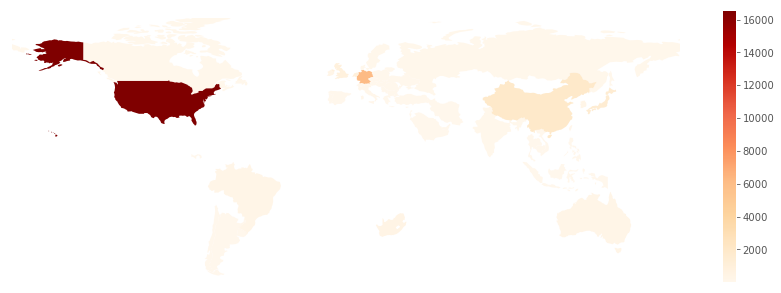

In [5]:
fig, ax = plt.subplots(figsize = (15, 5))
world.plot(ax=ax, column="Count", cmap='OrRd', legend=True)
ax.set_facecolor('white')
# geo_df.plot(ax=ax)

plt.xticks([])
plt.yticks([])
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

fig.savefig("madcat-overview-map.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

## Protocol Distribution

In [16]:
df = pd.read_csv("./data/Protocol used.csv")
df.Count = df.Count.str.replace(',', '').astype(int)
df["timestamp per 12 hours"] = pd.to_datetime(df["timestamp per 12 hours"])
df.head()

,Top 999 unusual terms in proto.keyword,timestamp per 12 hours,Count
0,ICMP,2021-10-14 12:00:00,21
1,ICMP,2021-10-15 00:00:00,9
2,ICMP,2021-10-15 12:00:00,10
3,ICMP,2021-10-16 00:00:00,9
4,ICMP,2021-10-16 12:00:00,13


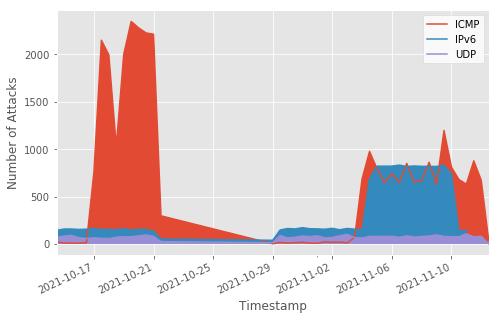

In [23]:
fig, ax = plt.subplots(figsize = (8,5))

for k, d in df.groupby('Top 999 unusual terms in proto.keyword'):
    x = d['timestamp per 12 hours'].to_numpy()
    y = d['Count'].to_numpy()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    
    #ax.scatter(x,y)
    ax.plot(x,y, label=k)
    ax.fill_between(x, y)


fig.autofmt_xdate()
ax.set_ylabel("Number of Attacks")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df["timestamp per 12 hours"].min()
datemax = df["timestamp per 12 hours"].max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='upper right',frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("madcat-protocol-usage.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()